In [248]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
rcParams['figure.figsize']=15,10
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [249]:
df = pd.read_csv('EXL_EQ_2023_Dataset.csv')
df.shape

(223584, 45)

In [250]:
df.head(), df.tail()

(        PM2.5          NO         NO2         NOx        NH3        SO2   
 0  549.256878  181.010975   91.247522  188.364425  79.707417  10.175812  \
 1  435.438303  194.247049   79.661701  203.481853  66.258913  11.615925   
 2  453.312378  112.499494  121.740909  153.914993  74.356791  10.590183   
 3  186.603123   56.922094  114.142207   91.504524        NaN  12.217971   
 4  262.616309   77.363086  123.790340  117.065760        NaN  13.331616   
 
          CO      Ozone   Benzene     Toluene  ...   
 0  3.520142  23.411029       NaN         NaN  ...  \
 1  3.464807  29.331609  9.827428         NaN  ...   
 2  2.460498  30.172308  9.085975         NaN  ...   
 3  1.405930  30.493537  3.884649  104.475114  ...   
 4  2.692100  18.045684  5.605006   96.718827  ...   
 
    Installed Capacity of Power as of 2022(Megawatt)   
 0                                              7617  \
 1                                              7617   
 2                                              

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223584 entries, 0 to 223583
Data columns (total 45 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   PM2.5                                             218044 non-null  float64
 1   NO                                                218735 non-null  float64
 2   NO2                                               218244 non-null  float64
 3   NOx                                               217612 non-null  float64
 4   NH3                                               217948 non-null  float64
 5   SO2                                               219700 non-null  float64
 6   CO                                                219762 non-null  float64
 7   Ozone                                             219154 non-null  float64
 8   Benzene                                           217487 non-null  float64
 9   Tolu

In [252]:
# changing the datatype to datetime
df['Time Periods'] = pd.to_datetime(df['Time Periods'])
df['date'] = df['Time Periods'].dt.date

In [253]:
df.columns


Index(['PM2.5', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene',
       'Toluene', 'Temp', 'RH', 'WS', 'WD', 'SR', 'BP', 'AT', 'RF', 'TOT-RF',
       'VWS', 'Eth-Benzene', 'Xylene', 'MP-Xylene', 'O Xylene', 'CH4', 'City',
       'State', 'Population as of 2021 (Estimated)', 'Latitude', 'Longitude',
       'Total Length of Roads as of 2019(Km)',
       'Length of National Highways as of 2022(Km)',
       'Railway Route as of 2021(Km)', 'Forest Cover as of 2021(sq Km)',
       'Number of Factories as of 2020 (Units)',
       'Installed Capacity of Power as of 2022(Megawatt)',
       'Death Rate as of 2020(Per 1000)', 'CNG ONLY', 'DIESEL',
       'DIESEL/HYBRID', 'ELECTRIC(BOV)', 'PETROL', 'PETROL/CNG',
       'PETROL/HYBRID', 'Time Periods', 'date'],
      dtype='object')

In [254]:
# handling the commas in the columns and converting them to int type
variables = ['CNG ONLY', 'DIESEL','PETROL/CNG',
       'PETROL/HYBRID', 'ELECTRIC(BOV)', 'PETROL' ]
for i in variables:
    
    df[i] = df[i].astype(str)
    df[i] = df[i].str.replace(',','')
    df[i] = df[i].str.replace('nan','0')
    df[i] = df[i].astype(int)


In [255]:
df.describe()

PM2.5             NO            NO2            NOx   
count  218044.000000  218735.000000  218244.000000  217612.000000  \
mean       69.213957      14.072135      30.366790      30.736544   
min         0.100000       0.010000       0.010000       0.000000   
25%        30.340937       4.006669      12.175122      13.329495   
50%        51.630955       6.727626      19.174929      21.085326   
75%        91.310000      13.334686      36.976778      35.779768   
max       890.873920     359.241357     300.479696     394.141771   
std        56.962718      22.097622      31.883841      31.688403   

                 NH3            SO2             CO          Ozone   
count  217948.000000  219700.000000  219762.000000  219154.000000  \
mean       26.234892      13.945535       0.987377      31.138962   
min         0.100000       0.010000       0.000000       0.030000   
25%        13.053931       6.357942       0.476443      14.784502   
50%        20.984008      11.360059       0.821914      27.112538   
75%        33.487317      18.810202       1.213776      42.196887   
max       412.902722     195.550000       9.472610     197.200000   
std        20.545715      10.851849       0.792493      21.908442   

             Benzene        Toluene  ...   
count  217487.000000  167030.000000  ...  \
mean        3.730146      19.040600  ...   
min         0.000000       0.000000  ...   
25%         0.872648       2.444047  ...   
50%         2.198147       8.847500  ...   
75%         4.028444      23.859738  ...   
max       205.880300     360.394123  ...   
std         5.709067      24.739317  ...   

       Installed Capacity of Power as of 2022(Megawatt)   
count                                     223584.000000  \
mean                                       20314.823529   
min                                          225.000000   
25%                                         7323.000000   
50%                                        25385.000000   
75%                                        29230.000000   
max                                        43446.000000   
std                                        13297.869679   

       Death Rate as of 2020(Per 1000)       CNG ONLY         DIESEL   
count                    223584.000000  223584.000000  223584.000000  \
mean                          5.938235   13155.112978  140184.632246   
min                           3.600000       0.000000    2047.000000   
25%                           5.500000     284.000000   61158.000000   
50%                           6.100000    6091.000000  138957.500000   
75%                           6.500000   26368.000000  249322.000000   
max                           7.900000   50007.000000  296334.000000   
std                           0.933690   16172.429387   91811.336685   

       DIESEL/HYBRID  ELECTRIC(BOV)        PETROL     PETROL/CNG   
count  223584.000000  223584.000000  2.235840e+05  223584.000000  \
mean       58.750295   38432.392014  1.157582e+06   21848.546962   
min         0.000000      74.000000  1.348100e+04       0.000000   
25%         1.000000    5698.000000  4.645750e+05    1960.000000   
50%        13.000000   23082.000000  9.498330e+05    8621.000000   
75%        46.000000   62262.000000  2.286272e+06   39685.000000   
max       457.000000  162851.000000  2.448577e+06  109369.000000   
std        94.245640   46467.843753  8.135046e+05   23985.699588   

       PETROL/HYBRID                   Time Periods  
count  223584.000000                         223584  
mean     7542.035960  2021-07-01 21:59:59.999999744  
min         0.000000            2020-01-01 00:00:00  
25%      2858.000000            2020-09-30 23:00:00  
50%      6370.000000            2021-07-01 22:00:00  
75%     12431.000000            2022-04-01 21:00:00  
max     22206.000000            2022-12-31 20:00:00  
std      5805.763694                            NaN  

[8 rows x 43 columns]

In [256]:
# getting percentage of null values in the columns
null_values = df.isnull().sum().sort_values(ascending = False)
null_percentage = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)
missing = pd.concat([null_values, null_percentage], axis = 1, keys=['Total', 'Percentage'])
missing

Total  Percentage
CH4                                               217008   97.058824
VWS                                               179561   80.310308
Temp                                              172116   76.980464
O Xylene                                          100446   44.925397
Xylene                                             85753   38.353818
BP                                                 64451   28.826302
Toluene                                            56554   25.294297
MP-Xylene                                          49322   22.059718
Eth-Benzene                                        44297   19.812241
RH                                                 27211   12.170370
AT                                                 21570    9.647381
SR                                                 16383    7.327447
WS                                                  7080    3.166595
Benzene                                             6097    2.726939
NOx                                                 5972    2.671032
RF                                                  5931    2.652694
WD                                                  5809    2.598129
NH3                                                 5636    2.520753
PM2.5                                               5540    2.477816
NO2                                                 5340    2.388364
NO                                                  4849    2.168760
Ozone                                               4430    1.981358
SO2                                                 3884    1.737155
CO                                                  3822    1.709425
TOT-RF                                                 0    0.000000
Installed Capacity of Power as of 2022(Megawatt)       0    0.000000
Time Periods                                           0    0.000000
PETROL/HYBRID                                          0    0.000000
PETROL/CNG                                             0    0.000000
PETROL                                                 0    0.000000
ELECTRIC(BOV)                                          0    0.000000
DIESEL/HYBRID                                          0    0.000000
DIESEL                                                 0    0.000000
CNG ONLY                                               0    0.000000
Death Rate as of 2020(Per 1000)                        0    0.000000
Railway Route as of 2021(Km)                           0    0.000000
Number of Factories as of 2020 (Units)                 0    0.000000
Forest Cover as of 2021(sq Km)                         0    0.000000
Length of National Highways as of 2022(Km)             0    0.000000
Total Length of Roads as of 2019(Km)                   0    0.000000
Longitude                                              0    0.000000
Latitude                                               0    0.000000
Population as of 2021 (Estimated)                      0    0.000000
State                                                  0    0.000000
City                                                   0    0.000000
date                                                   0    0.000000

In [257]:
df['CH4'].groupby(df['City']).unique()

City
Agartala                                                          [nan]
Agra                                                              [nan]
Ahmedabad                                                         [nan]
Bengaluru                                                         [nan]
Bhilai                                                            [nan]
Bhopal                                                            [nan]
Chandigarh                                                        [nan]
Chennai               [199.72, 199.73, 199.74000000000004, 199.93, 1...
Delhi                                                             [nan]
Faridabad                                                         [nan]
Gandhinagar                                                       [nan]
Gaya                                                              [nan]
Ghaziabad                                                         [nan]
Gurugram                                                   

In [258]:
df['VWS'].groupby(df['City']).unique()

City
Agartala                                                          [nan]
Agra                  [-0.2, nan, -0.19, -0.21, -0.22, -0.25, -0.16,...
Ahmedabad             [0.0, 17.44, 18.0, 19.62, 19.22, 19.44, 19.55,...
Bengaluru                                                         [nan]
Bhilai                                                            [nan]
Bhopal                                                            [nan]
Chandigarh                                                        [nan]
Chennai               [-0.4690538461538462, -0.4776561085972851, -0....
Delhi                 [-0.0094695932675482, -0.0125483051783151, -0....
Faridabad                                                         [nan]
Gandhinagar                                                       [nan]
Gaya                                                              [nan]
Ghaziabad                                                         [nan]
Gurugram                                                   

In [259]:
df['Temp'].groupby(df['City']).unique()

City
Agartala                                                          [nan]
Agra                                                              [nan]
Ahmedabad                                                         [nan]
Bengaluru             [24.27499581749049, 24.775283520735098, 25.584...
Bhilai                                                            [nan]
Bhopal                                                            [nan]
Chandigarh                                                        [nan]
Chennai               [27.01321645313553, 25.57587614273076, 27.5621...
Delhi                 [7.750000000000001, 7.49, 9.45, 11.32, 10.22, ...
Faridabad                                                         [nan]
Gandhinagar                                                       [nan]
Gaya                                                              [nan]
Ghaziabad             [31.427404175035, 31.37746521604261, 31.261751...
Gurugram                                                   

In [260]:
# dorping the columns that have lots of missing values
df.drop(['VWS', 'Temp', 'CH4'], axis = 1, inplace = True)
df.drop(['Population as of 2021 (Estimated)', 'Latitude', 'Longitude',
       'Total Length of Roads as of 2019(Km)',
       'Length of National Highways as of 2022(Km)',
       'Railway Route as of 2021(Km)', 'Forest Cover as of 2021(sq Km)',
       'Number of Factories as of 2020 (Units)',
       'Installed Capacity of Power as of 2022(Megawatt)',
       'Death Rate as of 2020(Per 1000)', 'CNG ONLY', 'DIESEL',
       'DIESEL/HYBRID', 'ELECTRIC(BOV)', 'PETROL', 'PETROL/CNG',
       'PETROL/HYBRID'], axis = 1, inplace = True)

In [261]:
# handling the missing values using interpolation
df.interpolate(limit_direction="both",inplace=True)

In [262]:
# do compare satistical values after treating the missig values
df.describe()

PM2.5             NO            NO2            NOx   
count  223584.000000  223584.000000  223584.000000  223584.000000  \
mean       69.173410      14.072064      30.394929      30.764962   
min         0.100000       0.010000       0.010000       0.000000   
25%        30.340937       4.002165      12.175122      13.343799   
50%        51.630955       6.728779      19.273598      21.161998   
75%        91.310000      13.308238      37.066533      35.730000   
max       890.873920     359.241357     300.479696     394.141771   
std        56.949821      22.146976      31.856360      31.662477   

                 NH3            SO2             CO          Ozone   
count  223584.000000  223584.000000  223584.000000  223584.000000  \
mean       26.299966      13.901436       0.987059      31.320153   
min         0.100000       0.010000       0.000000       0.030000   
25%        13.053931       6.353340       0.478178      14.925272   
50%        21.154196      11.303520       0.821096      27.140497   
75%        33.639033      18.810202       1.213776      42.574566   
max       412.902722     195.550000       9.472610     197.200000   
std        20.502360      10.812577       0.789791      21.897153   

             Benzene        Toluene  ...             SR             BP   
count  223584.000000  223584.000000  ...  223584.000000  223584.000000  \
mean        3.762475      17.246118  ...     144.994626     810.437099   
min         0.000000       0.000000  ...       0.000000     700.000000   
25%         0.885614       2.533076  ...      33.521118     742.919438   
50%         2.229026       7.551961  ...      92.763728     762.495818   
75%         4.088961      21.390475  ...     201.550000     857.676685   
max       205.880300     360.394123  ...     999.990000    1034.866907   
std         5.806603      22.845122  ...     147.496905      89.725890   

                  AT             RF         TOT-RF    Eth-Benzene   
count  223584.000000  223584.000000  223584.000000  223584.000000  \
mean       26.516262       0.481335       0.295794      12.417719   
min         3.610897       0.000000       0.000000       0.010000   
25%        23.188700       0.000000       0.000000       0.520547   
50%        27.089492       0.000000       0.000000       2.960883   
75%        30.870363       0.005204       0.000000       8.620000   
max        47.692741      21.155857     514.482968     414.819132   
std         6.105043       1.555405       3.285686      27.112756   

              Xylene      MP-Xylene       O Xylene   
count  223584.000000  223584.000000  223584.000000  \
mean        6.561053      10.697208      61.649540   
min         0.000000       0.010000       1.000000   
25%         0.223526       0.751479      47.210537   
50%         1.898006       2.673342      62.490384   
75%         5.283778       8.015027      77.187058   
max       186.620000     414.818536     100.000000   
std        15.192435      24.128876      19.015482   

                        Time Periods  
count                         223584  
mean   2021-07-01 21:59:59.999999744  
min              2020-01-01 00:00:00  
25%              2020-09-30 23:00:00  
50%              2021-07-01 22:00:00  
75%              2022-04-01 21:00:00  
max              2022-12-31 20:00:00  
std                              NaN  

[8 rows x 23 columns]

In [263]:
df.shape
df.columns

Index(['PM2.5', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene',
       'Toluene', 'RH', 'WS', 'WD', 'SR', 'BP', 'AT', 'RF', 'TOT-RF',
       'Eth-Benzene', 'Xylene', 'MP-Xylene', 'O Xylene', 'City', 'State',
       'Time Periods', 'date'],
      dtype='object')

In [264]:
df_city = df[df['City'] == 'Delhi']
df_city.set_index('Time Periods', inplace = True)
# df_city.is_copy = None
df_city = df_city.iloc[:,0:22]
df_city.reset_index(inplace = True)
df_city['date'] = df_city['Time Periods'].dt.date
df_city.set_index('Time Periods', inplace = True)


TypeError: unsupported operand type(s) for +: 'datetime.date' and 'datetime.date'

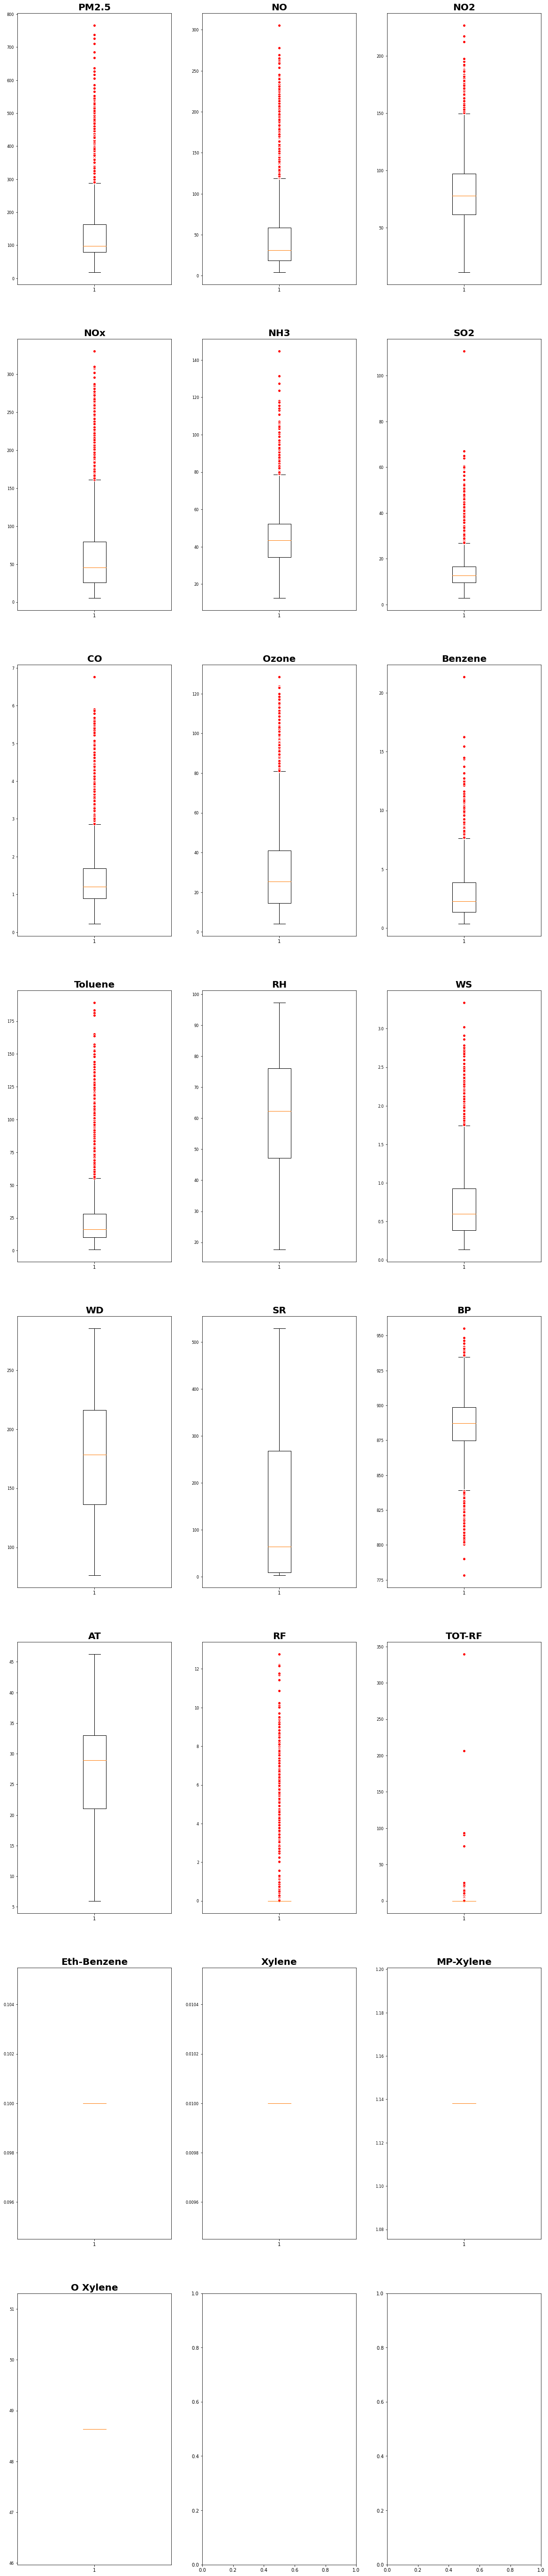

In [265]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(8, 3, figsize=(20,100))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_city.iloc[:,i], flierprops=red_circle)
    ax.set_title(df_city.columns[i], fontsize= 20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=8)
    
plt.tight_layout()

In [ ]:
df_city

In [ ]:
#anamoly detection and removing in a time series problem
import plotly.express as px
from sklearn.ensemble import IsolationForest

df_anamoly = df_city.iloc[:,:1]

In [266]:
df_anamoly.reset_index(inplace = True)
fig = px.line(df_anamoly, x='Time Periods', y='PM2.5')
fig.update_xaxes(
    rangeslider_visible = True,
)
fig.show()

In [267]:
df_anamoly['weekday'] = pd.Categorical(df_anamoly['Time Periods'].dt.strftime('%A'), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [268]:
df_anamoly['hour'] = df_anamoly['Time Periods'].dt.hour

<AxesSubplot:xlabel='hour'>

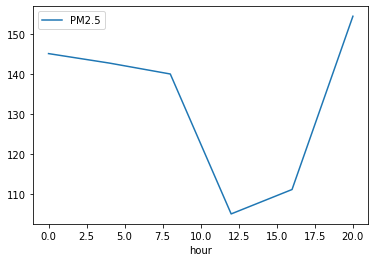

In [269]:
df_anamoly[['PM2.5','hour']].groupby('hour').mean().plot()

<AxesSubplot:xlabel='weekday'>

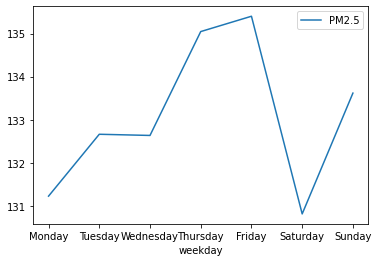

In [270]:
df_anamoly[['PM2.5','weekday']].groupby('weekday').mean().plot()

<AxesSubplot:xlabel='hour'>

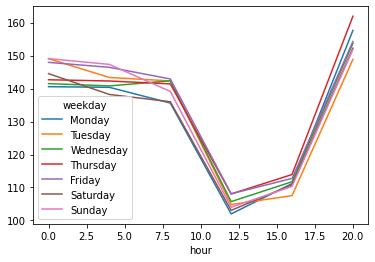

In [271]:
 df_anamoly.groupby(['hour', 'weekday']).mean()['PM2.5'].unstack().plot()

In [272]:
df_anamoly2 = df_anamoly.join(df_anamoly.groupby(['hour', 'weekday']).mean()['PM2.5'], on = ['hour', 'weekday'], rsuffix='_avg')

In [273]:
df_anamoly2['day'] = df_anamoly2['Time Periods'].dt.weekday

In [274]:
df_anamoly2.reset_index( inplace= True)

In [275]:
data = df_anamoly2[[ 'PM2.5', 'day', 'hour']]

In [276]:
model = IsolationForest(contamination=.005, max_features=3, max_samples=0.8, n_estimators=200)
model.fit(data)

# df_anamoly2.query('outliers=="yes"')

IsolationForest(contamination=0.005, max_features=3, max_samples=0.8,
                n_estimators=200)

In [277]:
df_anamoly2['oultiers'] = pd.Series(model.predict(data)).apply(lambda x: 'yes' if (x == -1) else 'no')

In [278]:
# df_anamoly2.set_index( inplace = True)

In [279]:
df_anamoly2.query('oultiers=="yes"')

level_0  index        Time Periods       PM2.5    weekday  hour   
5           5      5 2020-01-01 20:00:00  725.493847  Wednesday    20  \
11         11     11 2020-01-02 20:00:00  604.720566   Thursday    20   
71         71     71 2020-01-12 20:00:00  523.667487     Sunday    20   
1852     1852   1852 2020-11-04 16:00:00  446.324704  Wednesday    16   
1878     1878   1878 2020-11-09 00:00:00  435.759049     Monday     0   
1879     1879   1879 2020-11-09 04:00:00  488.944852     Monday     4   
1880     1880   1880 2020-11-09 08:00:00  509.692758     Monday     8   
1881     1881   1881 2020-11-09 12:00:00  391.606389     Monday    12   
1882     1882   1882 2020-11-09 16:00:00  444.649068     Monday    16   
1883     1883   1883 2020-11-09 20:00:00  685.406265     Monday    20   
1884     1884   1884 2020-11-10 00:00:00  710.015917    Tuesday     0   
1885     1885   1885 2020-11-10 04:00:00  737.926721    Tuesday     4   
1886     1886   1886 2020-11-10 08:00:00  765.792213    Tuesday     8   
1913     1913   1913 2020-11-14 20:00:00  584.829098   Saturday    20   
1914     1914   1914 2020-11-15 00:00:00  668.041948     Sunday     0   
2141     2141   2141 2020-12-22 20:00:00  502.436463    Tuesday    20   
2142     2142   2142 2020-12-23 00:00:00  565.116231  Wednesday     0   
2284     2284   2284 2021-01-15 16:00:00  512.052935     Friday    16   
2285     2285   2285 2021-01-15 20:00:00  604.924683     Friday    20   
2303     2303   2303 2021-01-18 20:00:00  528.668904     Monday    20   
4043     4043   4043 2021-11-04 20:00:00  616.528707   Thursday    20   
4044     4044   4044 2021-11-05 00:00:00  626.381117     Friday     0   
4045     4045   4045 2021-11-05 04:00:00  636.233527     Friday     4   
4319     4319   4319 2021-12-20 20:00:00  498.522382     Monday    20   
4325     4325   4325 2021-12-21 20:00:00  528.220077    Tuesday    20   
4349     4349   4349 2021-12-25 20:00:00  577.326085   Saturday    20   
4350     4350   4350 2021-12-26 00:00:00  566.032921     Sunday     0   
4352     4352   4352 2021-12-26 08:00:00  478.498181     Sunday     8   
4392     4392   4392 2022-01-02 00:00:00  502.110036     Sunday     0   
6077     6077   6077 2022-10-09 20:00:00   21.897738     Sunday    20   
6222     6222   6222 2022-11-03 00:00:00  575.798108   Thursday     0   
6497     6497   6497 2022-12-18 20:00:00  480.379099     Sunday    20   
6498     6498   6498 2022-12-19 00:00:00  453.808523     Monday     0   

       PM2.5_avg  day oultiers  
5     153.694235    2      yes  
11    161.931621    3      yes  
71    151.832570    6      yes  
1852  111.740691    2      yes  
1878  140.573521    0      yes  
1879  140.374176    0      yes  
1880  135.610059    0      yes  
1881  101.985457    0      yes  
1882  111.166639    0      yes  
1883  157.635853    0      yes  
1884  149.070545    1      yes  
1885  143.360917    1      yes  
1886  142.321389    1      yes  
1913  152.242547    5      yes  
1914  149.080114    6      yes  
2141  148.851528    1      yes  
2142  141.498697    2      yes  
2284  112.749635    4      yes  
2285  154.272450    4      yes  
2303  157.635853    0      yes  
4043  161.931621    3      yes  
4044  147.943355    4      yes  
4045  146.438392    4      yes  
4319  157.635853    0      yes  
4325  148.851528    1      yes  
4349  152.242547    5      yes  
4350  149.080114    6      yes  
4352  139.125045    6      yes  
4392  149.080114    6      yes  
6077  151.832570    6      yes  
6222  142.673401    3      yes  
6497  151.832570    6      yes  
6498  140.573521    0      yes

In [280]:
fig = px.scatter(df_anamoly2, x = 'Time Periods', y='PM2.5', color='oultiers', hover_data=['weekday', 'hour', 'PM2.5_avg'], title = 'Outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

(array([  3.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   5.,   1.,   4.,
          3.,   3.,   3.,   6.,   8.,   5.,  11.,  11.,  12.,  17.,  12.,
         32.,  17.,  41.,  30.,  48.,  45.,  66.,  86.,  93., 126., 137.,
        186., 232., 250., 213., 321., 319., 341., 407., 473., 424., 448.,
        429., 458., 431., 471., 296.,  49.]),
 array([-0.10697728, -0.0999294 , -0.09288152, -0.08583364, -0.07878576,
        -0.07173788, -0.06469   , -0.05764212, -0.05059424, -0.04354636,
        -0.03649848, -0.0294506 , -0.02240272, -0.01535484, -0.00830696,
        -0.00125908,  0.0057888 ,  0.01283668,  0.01988456,  0.02693244,
         0.03398032,  0.0410282 ,  0.04807608,  0.05512396,  0.06217184,
         0.06921972,  0.0762676 ,  0.08331548,  0.09036336,  0.09741124,
         0.10445912,  0.111507  ,  0.11855488,  0.12560276,  0.13265064,
         0.13969852,  0.1467464 ,  0.15379428,  0.16084216,  0.16789004,
         0.17493792,  0.1819858 ,  0.18903368,  0.19608156,  0.20312944,
 

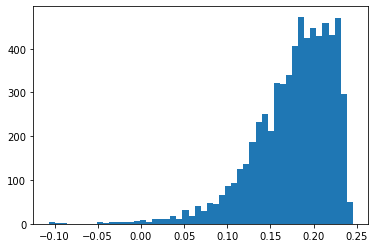

In [281]:
score = model.decision_function(data)
plt.hist(score, bins=50)

In [282]:
df_anamoly2['Scores'] = score
df_removed = df_anamoly2.query('Scores>-0.02')

In [283]:
df_city.reset_index(inplace=True)

In [284]:
df_final=pd.merge(df_city, df_removed, suffixes=['_l', '_r'], left_index=True, right_index=True)

In [285]:
df_final.drop(['RH', 'WS', 'WD'], axis=1, inplace=True)

In [286]:
df_final.drop(['SR', 'BP', 'O Xylene'
       , 'date', 'index', 'Time Periods_r', 'weekday', 'hour', 'PM2.5_avg', 'day', 'oultiers', 'Scores'], axis=1, inplace=True)
# df_final.drop(['AT', 'RF', 'TOT-RF', 'Eth-Benzene', 'Xylene',
#        'MP-Xylene', 'PM2.5_r'], axis=1, inplace=True)

In [287]:
df_final.drop('Ozone', axis=1, inplace=True)

In [288]:
# df_final.set_index('Time Periods_l', inplace=True)
df_final.columns

Index(['Time Periods_l', 'PM2.5_l', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Benzene', 'Toluene', 'AT', 'RF', 'TOT-RF', 'Eth-Benzene', 'Xylene',
       'MP-Xylene', 'level_0', 'PM2.5_r'],
      dtype='object')

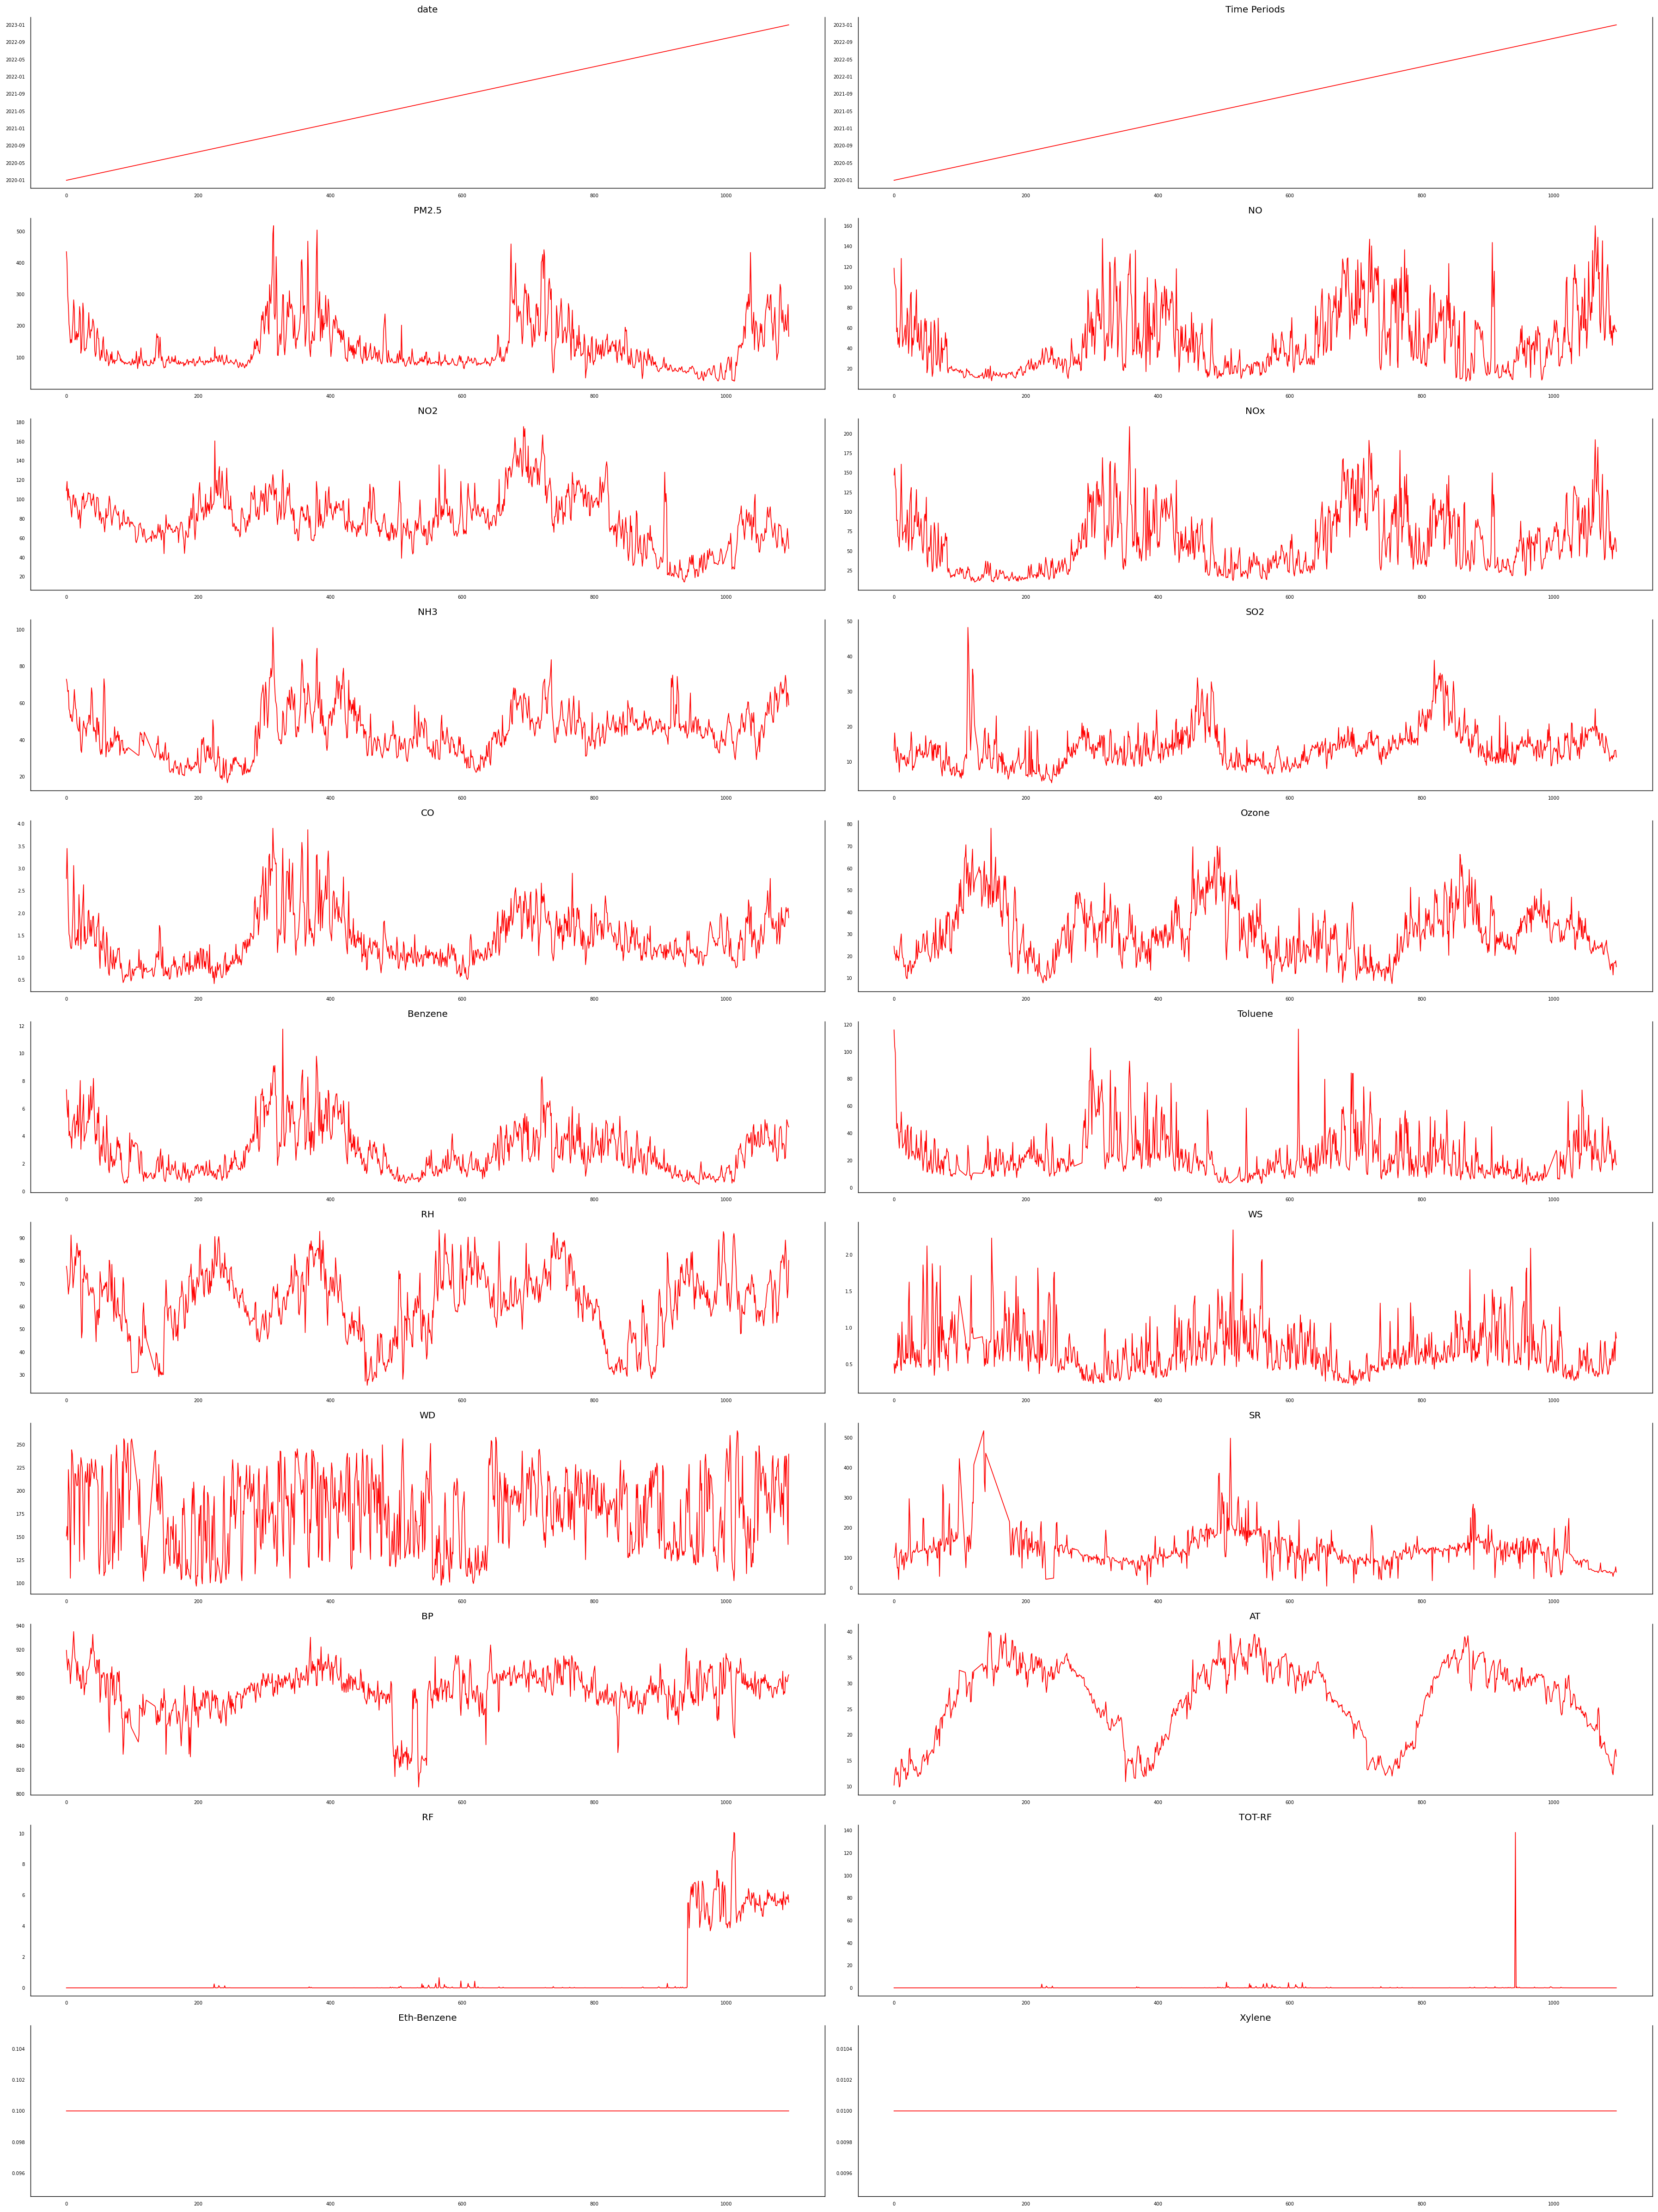

In [289]:
# drawing graph of mean of values in a day   
grp_srs = df_city.groupby(df_city['date']).mean()
grp_df = grp_srs.reset_index()
type(grp_df)
fig, axes = plt.subplots(nrows=11, ncols=2, dpi=120, figsize=(30,40))
for i, ax in enumerate(axes.flatten()):
    data = grp_df[grp_df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(grp_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    

plt.tight_layout();

In [290]:
df_city.drop(['Xylene', 'MP-Xylene', 'Eth-Benzene', 'TOT-RF', 'RF', 'AT'], axis = 1, inplace = True)

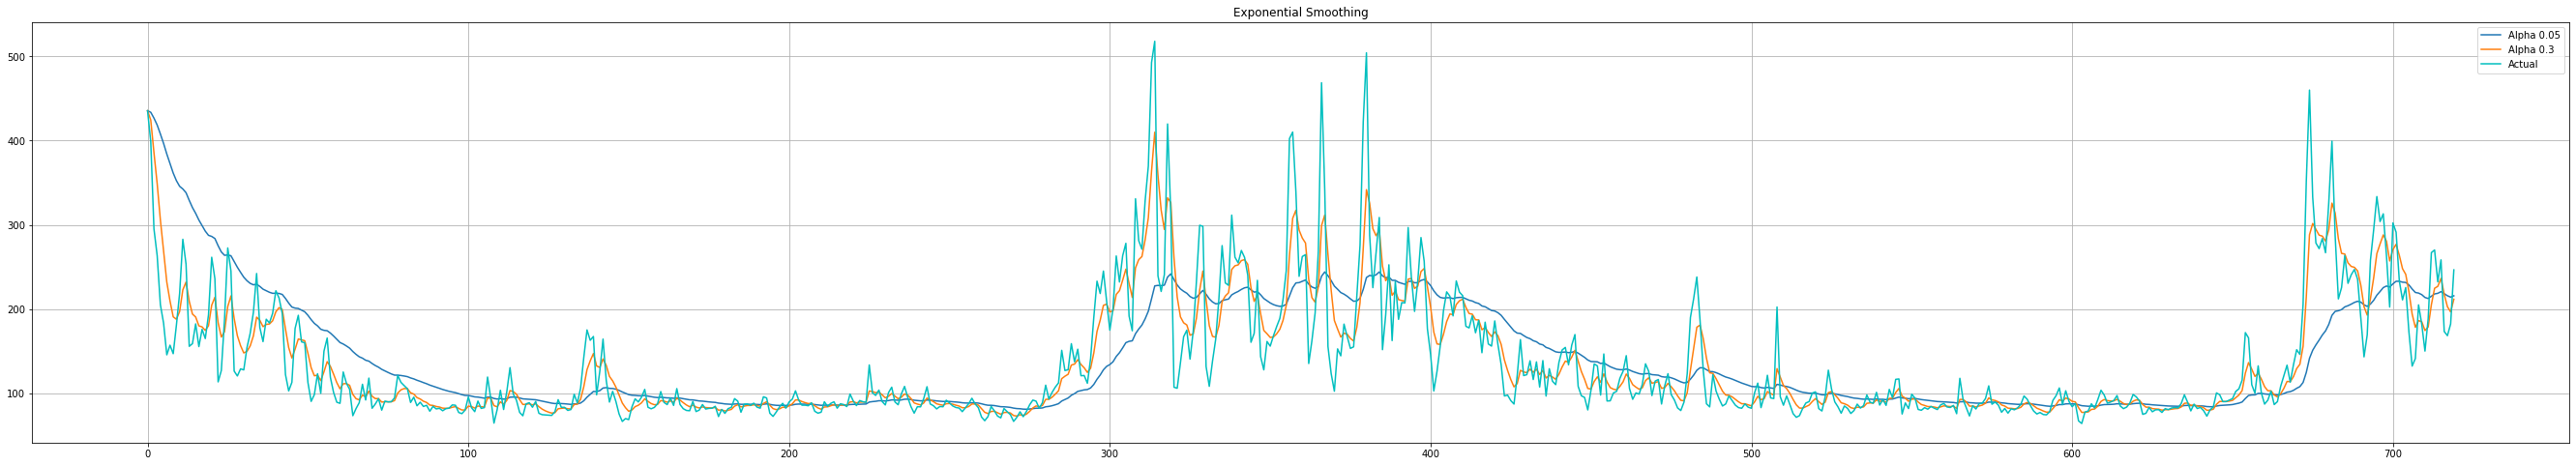

In [291]:
def exponential_smoothing(series, alpha):

    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(47, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    
    plt.grid(True);

plot_exponential_smoothing(grp_df[0:720]['PM2.5'], [0.05, 0.3])

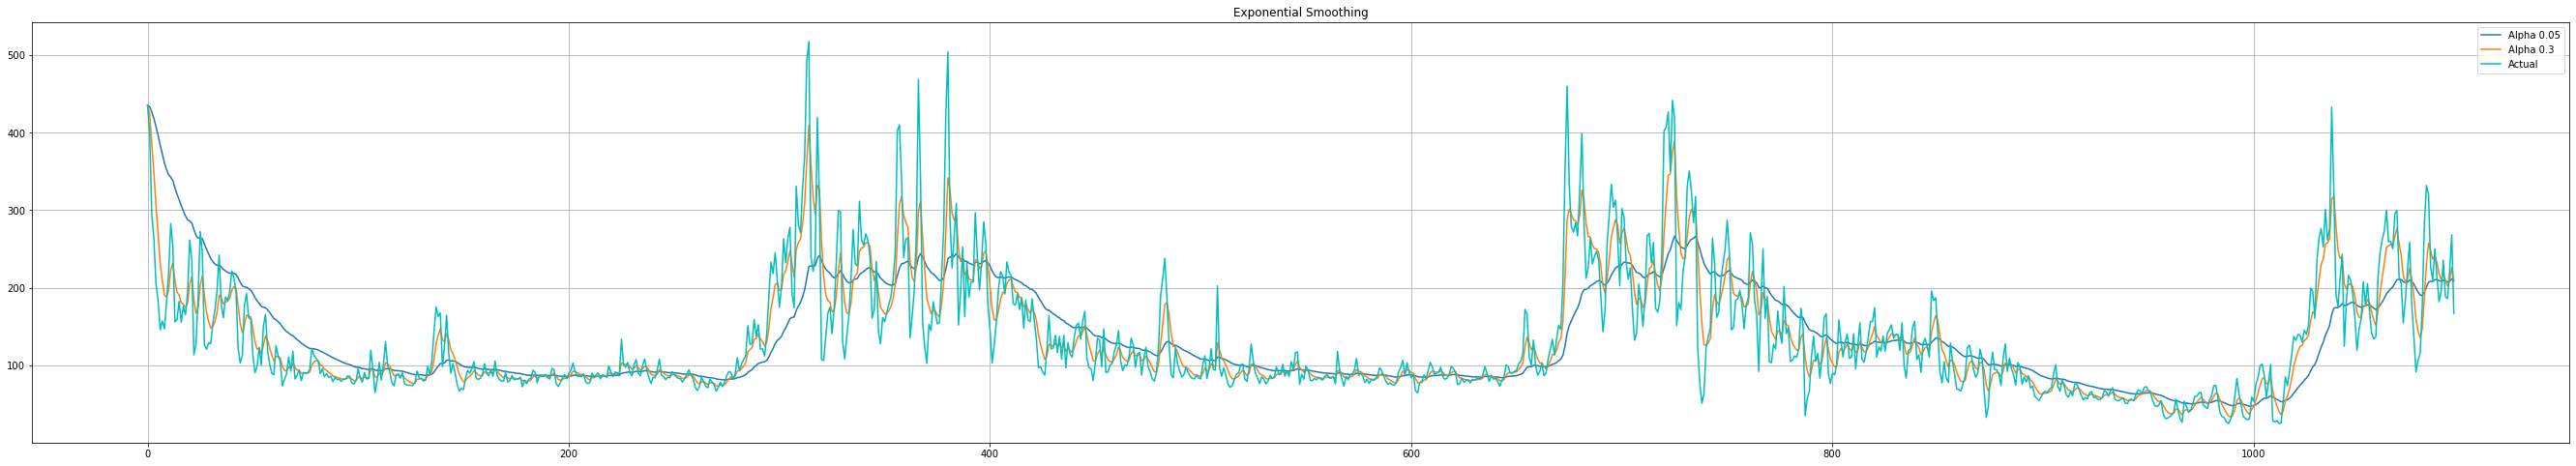

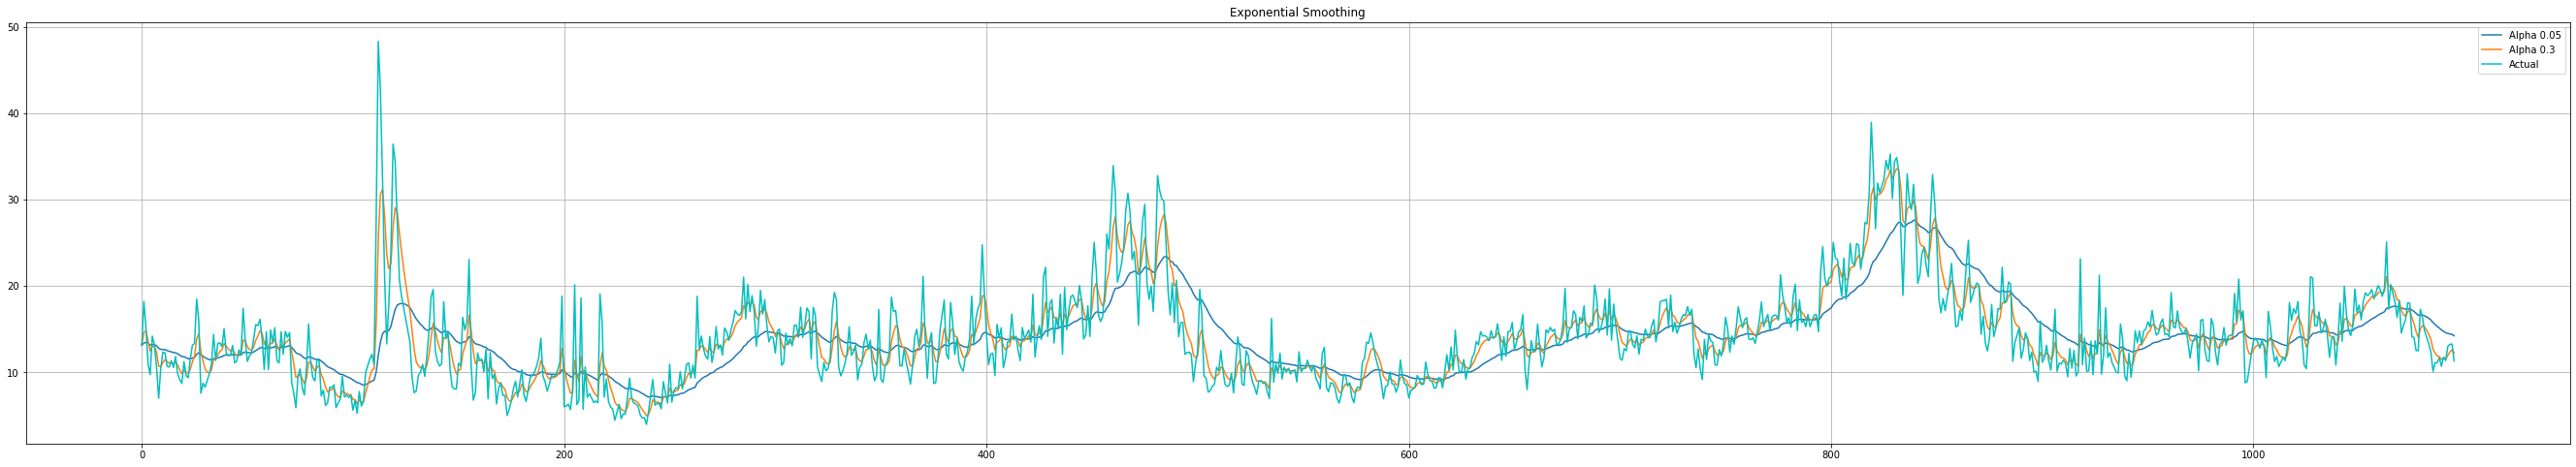

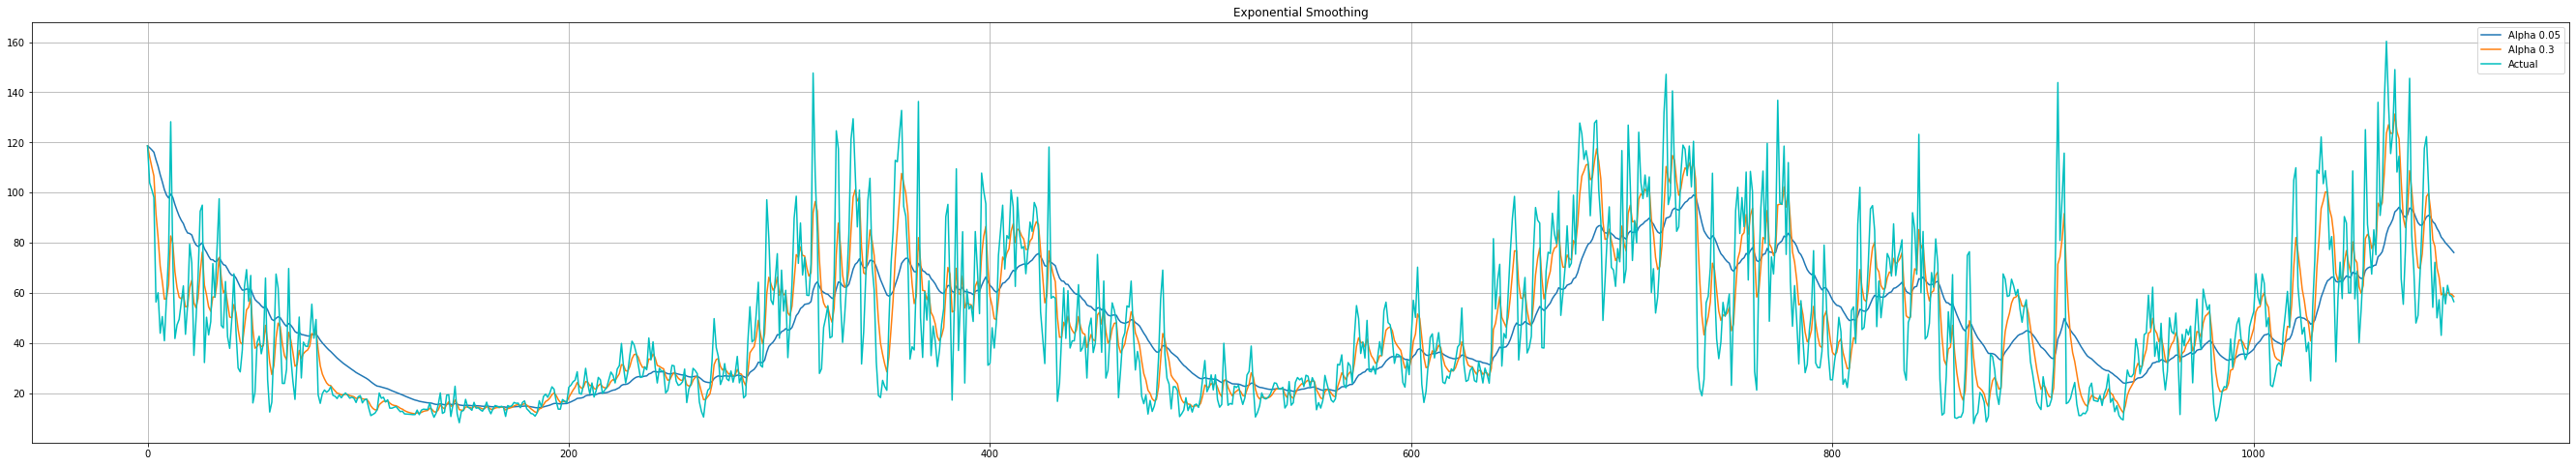

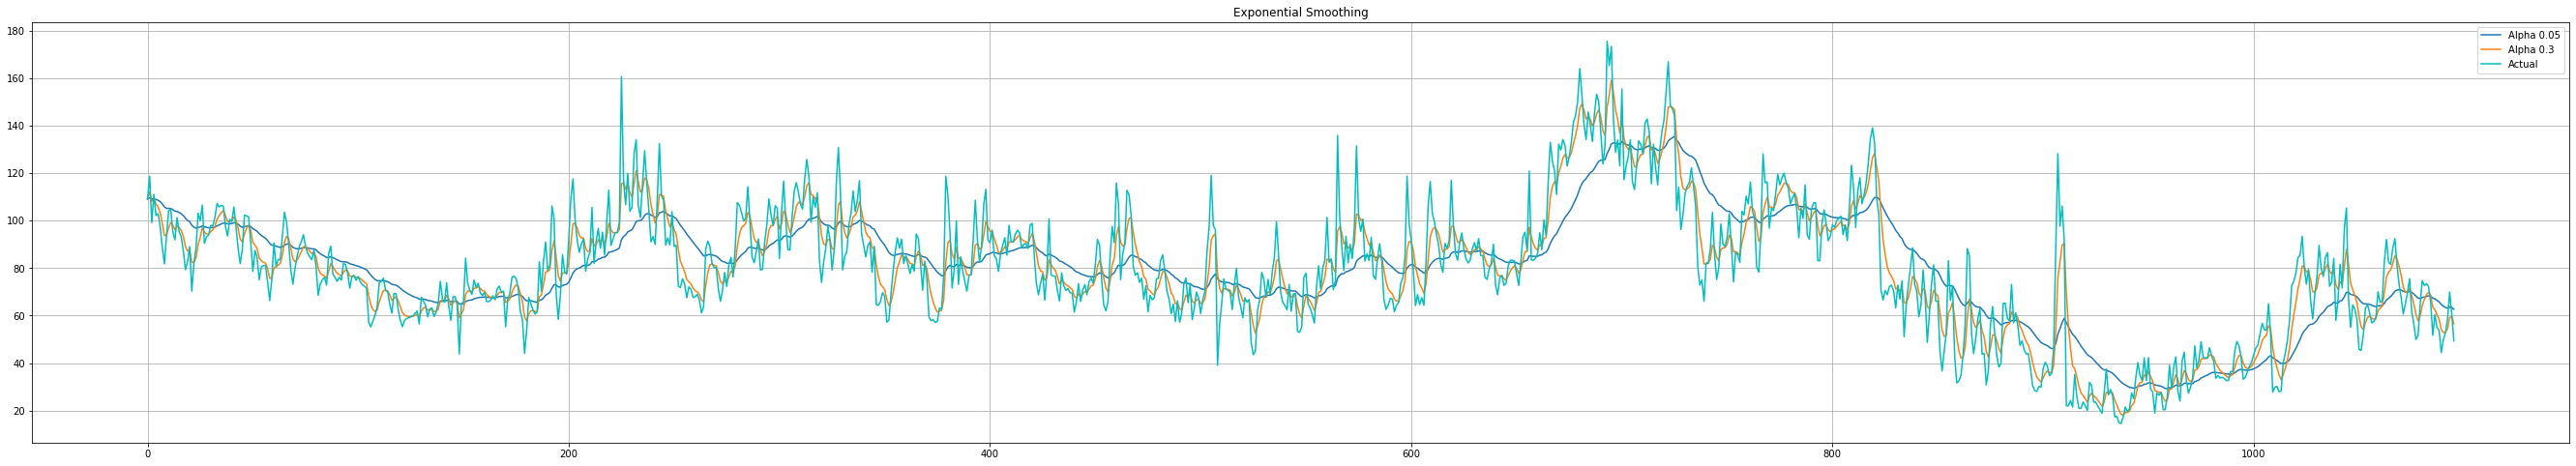

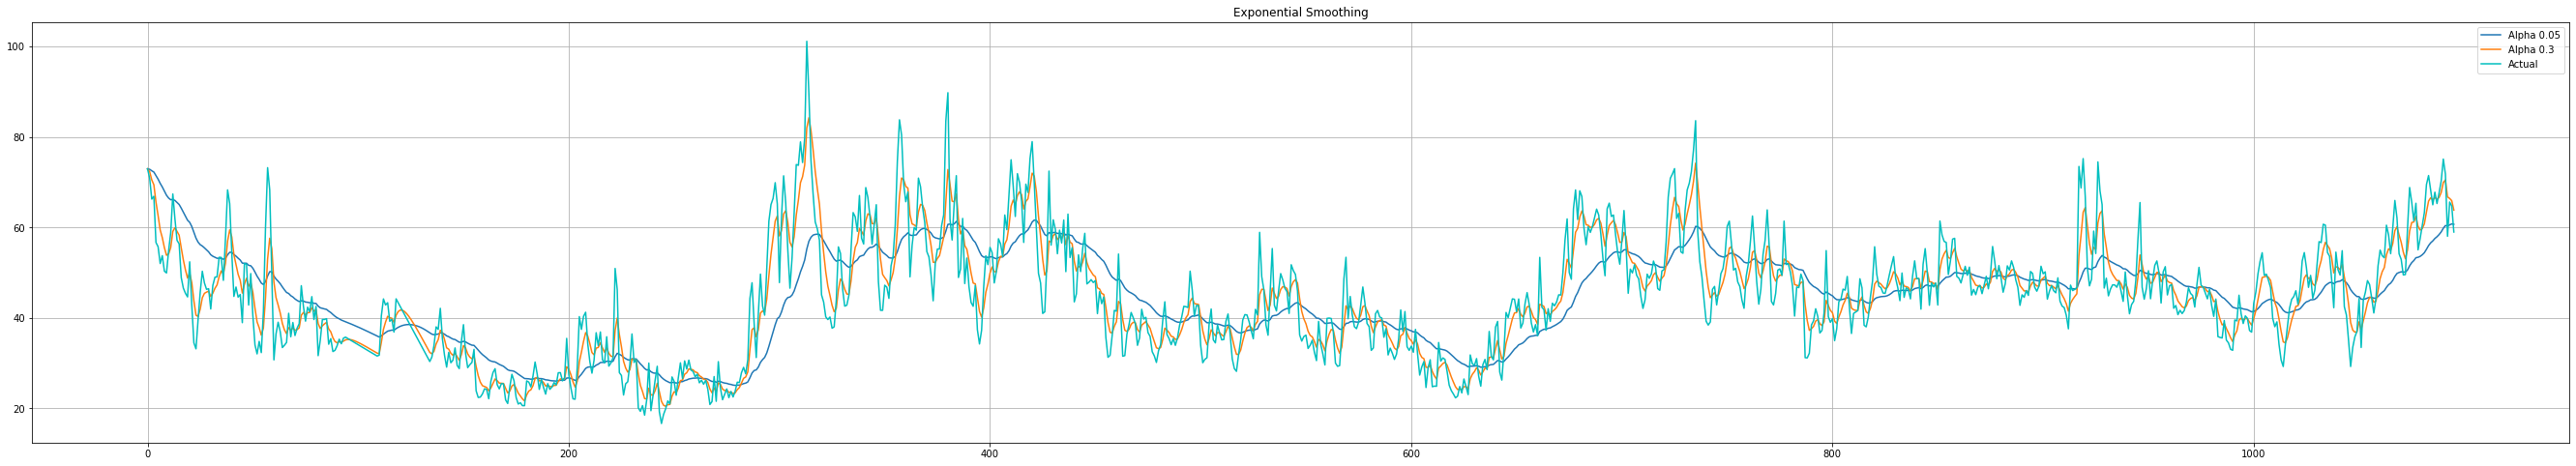

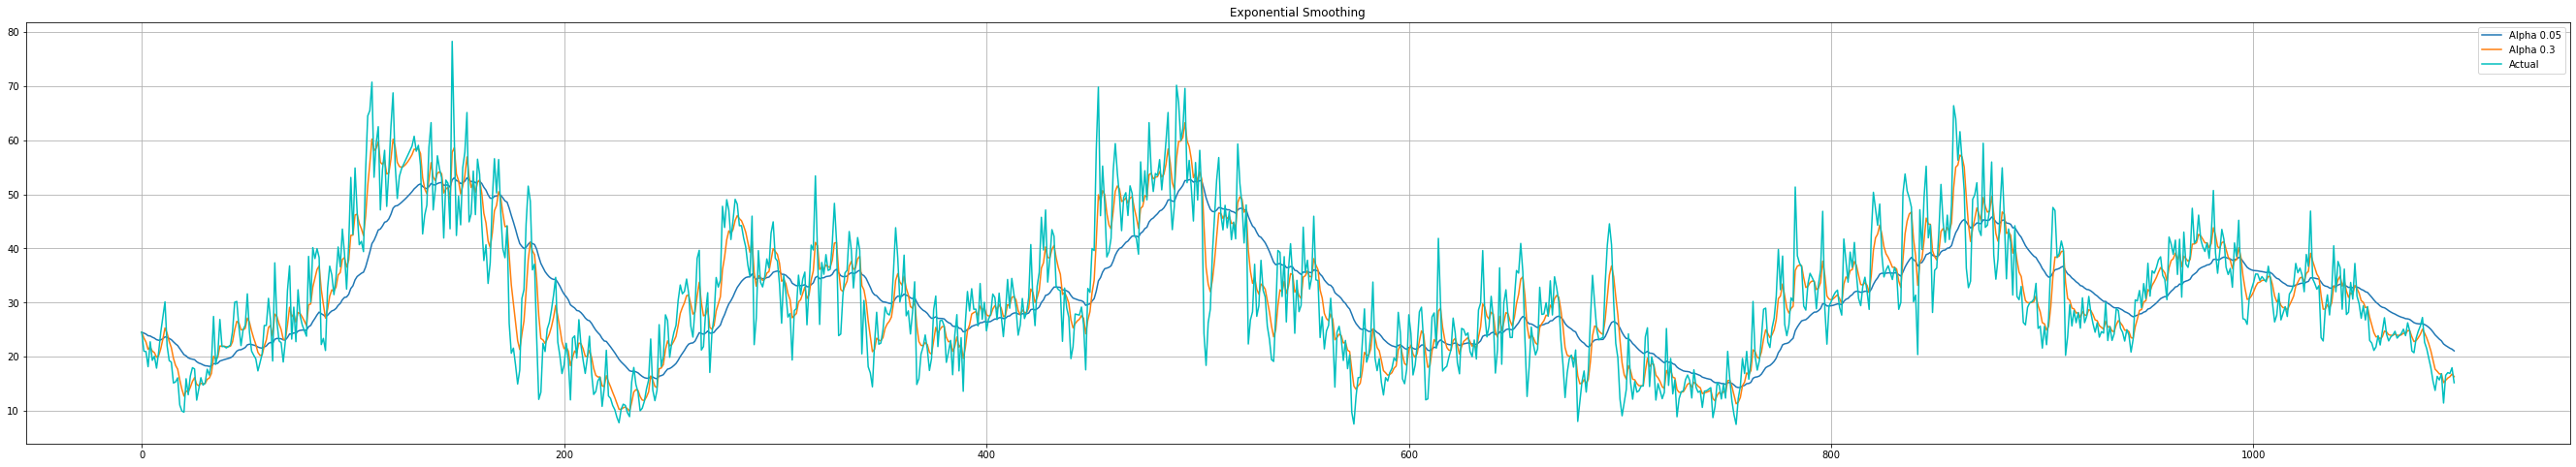

In [292]:
plot_exponential_smoothing(grp_df['PM2.5'], [0.05, 0.3])
plot_exponential_smoothing(grp_df['SO2'], [0.05, 0.3])
plot_exponential_smoothing(grp_df['NO'], [0.05, 0.3])
plot_exponential_smoothing(grp_df['NO2'], [0.05, 0.3])
plot_exponential_smoothing(grp_df['NH3'], [0.05, 0.3])
plot_exponential_smoothing(grp_df['Ozone'], [0.05, 0.3])

In [293]:
df_city.columns

Index(['Time Periods', 'PM2.5', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Benzene', 'Toluene', 'RH', 'WS', 'WD', 'SR', 'BP', 'O Xylene',
       'date'],
      dtype='object')

In [294]:
ad_fuller_result_1 = adfuller(df_final['PM2.5_l'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df_final['NO'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
print('\n---------------------\n')
ad_fuller_result_3 = adfuller(df_final['NO2'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(df_final['NH3'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')
print('\n---------------------\n')     
ad_fuller_result_5 = adfuller(df_final['SO2'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

print('\n---------------------\n')

ad_fuller_result_6 = adfuller(df_final['CO'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')
print('\n---------------------\n')

ad_fuller_result_8 = adfuller(df_final['Benzene'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_8[0]}')
print(f'p-value: {ad_fuller_result_8[1]}')
print('\n---------------------\n')
ad_fuller_result_9 = adfuller(df_final['Toluene'].diff()[1:])

print(f'ADF Statistic: {ad_fuller_result_9[0]}')
print(f'p-value: {ad_fuller_result_9[1]}')

     

ADF Statistic: -19.491684074885278
p-value: 0.0

---------------------

ADF Statistic: -20.798401390867635
p-value: 0.0

---------------------

ADF Statistic: -19.54831602913499
p-value: 0.0

---------------------

ADF Statistic: -19.945490445009078
p-value: 0.0

---------------------

ADF Statistic: -21.135837359019902
p-value: 0.0

---------------------

ADF Statistic: -20.25442956335043
p-value: 0.0

---------------------

ADF Statistic: -20.380985788779313
p-value: 0.0

---------------------

ADF Statistic: -20.541164213483107
p-value: 0.0


In [295]:
print('NO causes PM2.5?\n')
print('------------------')
granger_1 = grangercausalitytests(df_final[['PM2.5_l','NO']], 1)

print('NO2 causes PM2.5?\n')
print('------------------')
granger_2 = grangercausalitytests(df_final[['PM2.5_l','NO2']], 1)

print('NOx causes PM2.5?\n')
print('------------------')
granger_3 = grangercausalitytests(df_final[['PM2.5_l','NOx']], 1)

print('NH3 causes PM2.5?\n')
print('------------------')
granger_4 = grangercausalitytests(df_final[['PM2.5_l','NH3']], 1)

print('SO2 causes PM2.5?\n')
print('------------------')
granger_5 = grangercausalitytests(df_final[['PM2.5_l','SO2']], 1)

print('CO causes PM2.5?\n')
print('------------------')
granger_6 = grangercausalitytests(df_final[['PM2.5_l','CO']], 1)



print('Benzene causes PM2.5?\n')
print('------------------')
granger_8 = grangercausalitytests(df_final[['PM2.5_l','Benzene']], 1)

print('Toluene causes PM2.5?\n')
print('------------------')
granger_9 = grangercausalitytests(df_final[['PM2.5_l','Toluene']], 1)




NO causes PM2.5?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=180.4547, p=0.0000  , df_denom=6552, df_num=1
ssr based chi2 test:   chi2=180.5373, p=0.0000  , df=1
likelihood ratio test: chi2=178.0958, p=0.0000  , df=1
parameter F test:         F=180.4547, p=0.0000  , df_denom=6552, df_num=1
NO2 causes PM2.5?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=271.0705, p=0.0000  , df_denom=6552, df_num=1
ssr based chi2 test:   chi2=271.1946, p=0.0000  , df=1
likelihood ratio test: chi2=265.7348, p=0.0000  , df=1
parameter F test:         F=271.0705, p=0.0000  , df_denom=6552, df_num=1
NOx causes PM2.5?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=275.2779, p=0.0000  , df_denom=6552, df_num=1
ssr based chi2 test:   chi2=275.4040, p=0.0000  , df=1
likelihood ratio test: chi2=269.7756, p=0.0000  , df=1
parameter F test:         F=275.2779, p=0.0000  ,

In [296]:

df_city.set_index('Time Periods', inplace = True)

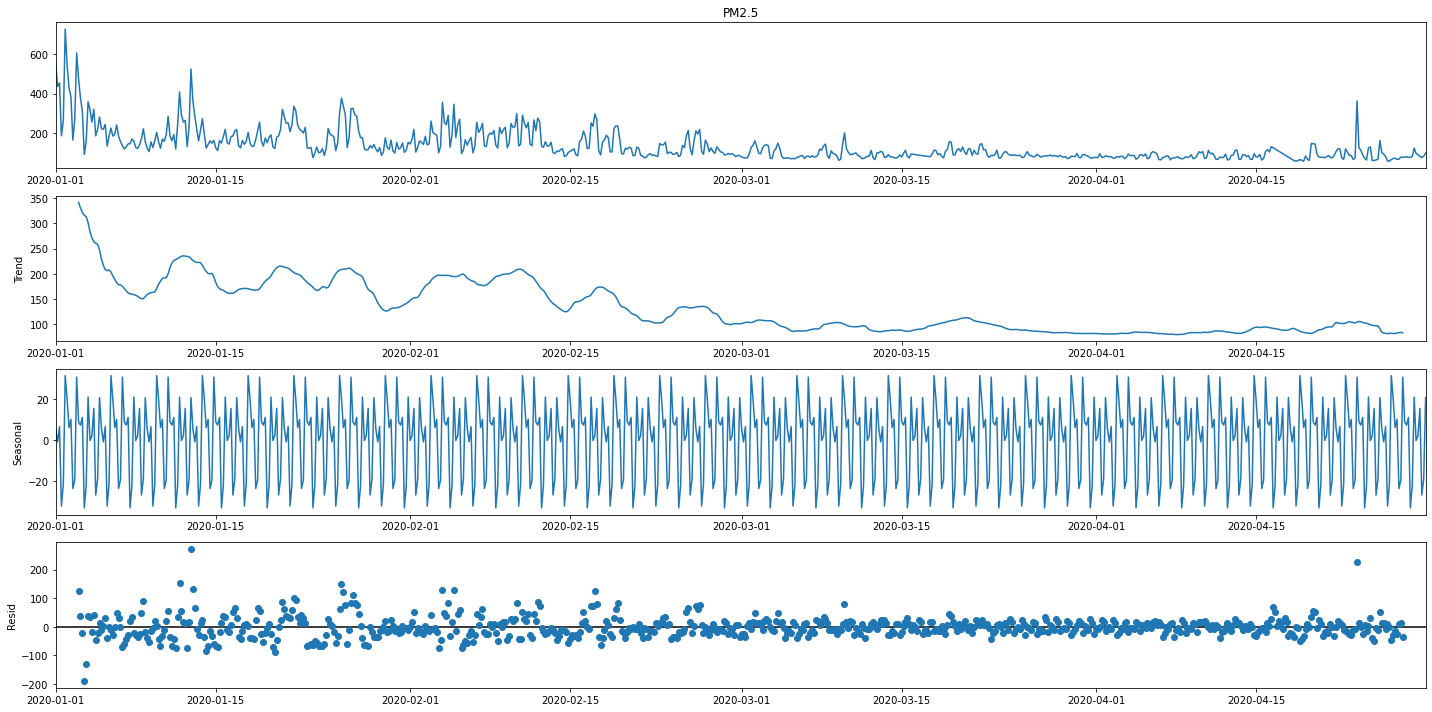

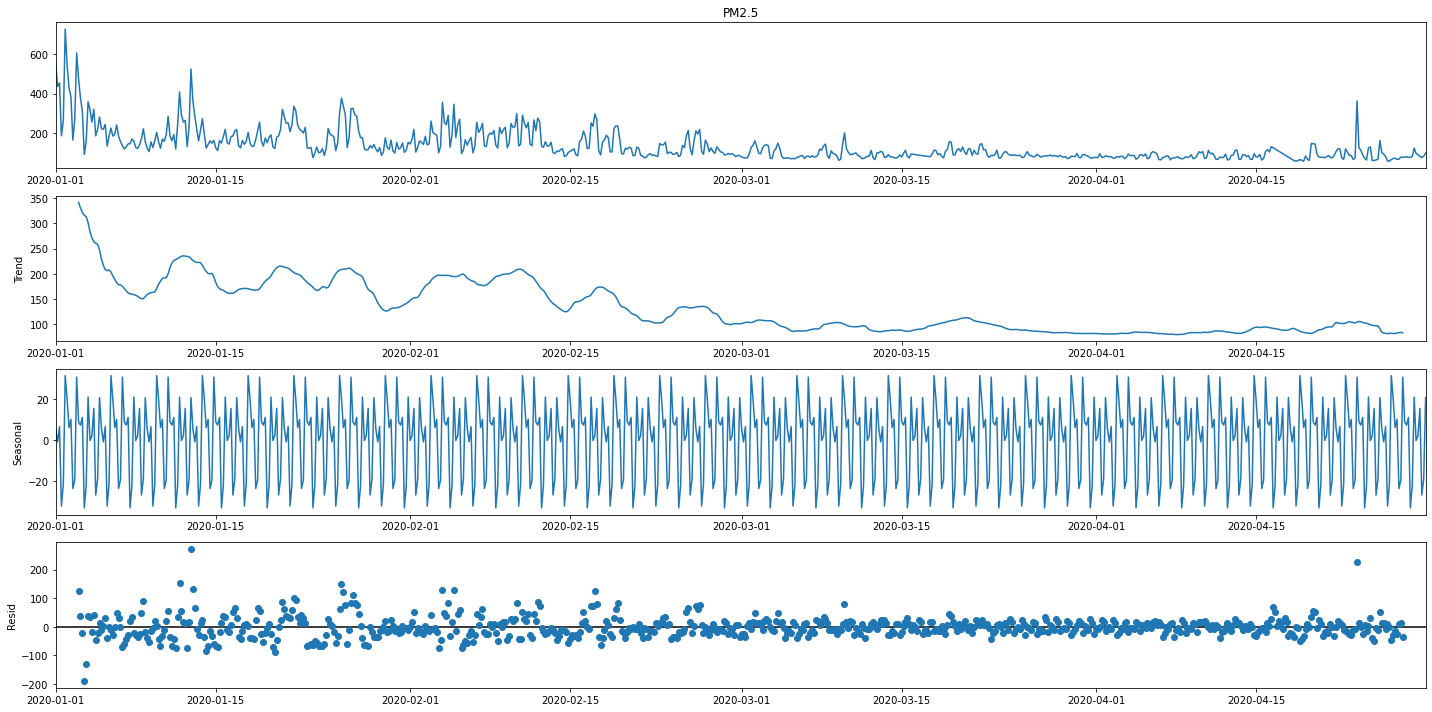

In [297]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_city['PM2.5'][0:720])
rcParams['figure.figsize'] = 20,10
result.plot()


In [298]:
df_final.reset_index(inplace = True)
df_final.set_index('Time Periods_l', inplace=True)

In [299]:
df_final.drop(['AT', 'RF', 'TOT-RF', 'Eth-Benzene', 'Xylene', 'MP-Xylene', 'PM2.5_r'], axis=1, inplace = True)

In [300]:
df_final.drop('index', axis = 1, inplace = True)

In [314]:
df_final.drop('level_0', axis=1, inplace=True)

In [315]:
def df_to_X_y(df, window_size=30):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0],df_as_np[i+window_size][1],df_as_np[i+window_size][2],df_as_np[i+window_size][3],df_as_np[i+window_size][4],df_as_np[i+window_size][5],df_as_np[i+window_size][6],df_as_np[i+window_size][7],df_as_np[i+window_size][8]]
        y.append(label)
    return np.array(X), np.array(y)

In [316]:
X2, y2 = df_to_X_y(df_final)
X2.shape, y2.shape

((6526, 30, 9), (6526, 9))

In [317]:
X2_train, y2_train = X2[:4588], y2[:4588]
X2_val, y2_val = X2[4588:5577], y2[4588:5577]
X2_test, y2_test = X2[5577:], y2[5577:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((4588, 30, 9), (4588, 9), (989, 30, 9), (989, 9), (949, 30, 9), (949, 9))

In [318]:
training_mean0 = np.mean(X2_train[:, :, 0])
training_std0 = np.std(X2_train[:, :, 0])
training_mean1 = np.mean(X2_train[:, :, 1])
training_std1 = np.std(X2_train[:, :, 1])
training_mean2 = np.mean(X2_train[:, :, 2])
training_std2 = np.std(X2_train[:, :, 2])
training_mean3 = np.mean(X2_train[:, :, 3])
training_std3 = np.std(X2_train[:, :, 3])
training_mean4 = np.mean(X2_train[:, :, 4])
training_std4 = np.std(X2_train[:, :, 4])
training_mean5 = np.mean(X2_train[:, :, 5])
training_std5 = np.std(X2_train[:, :, 5])
training_mean6 = np.mean(X2_train[:, :, 6])
training_std6 = np.std(X2_train[:, :, 6])
training_mean7 = np.mean(X2_train[:, :, 7])
training_std7 = np.std(X2_train[:, :, 7])
training_mean8 = np.mean(X2_train[:, :, 8])
training_std8 = np.std(X2_train[:, :, 8])
def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - training_mean0) / training_std0
    X[:, :, 1] = (X[:, :, 1] - training_mean1) / training_std1
    X[:, :, 2] = (X[:, :, 2] - training_mean2) / training_std2
    X[:, :, 3] = (X[:, :, 3] - training_mean3) / training_std3
    X[:, :, 4] = (X[:, :, 4] - training_mean4) / training_std4
    X[:, :, 5] = (X[:, :, 5] - training_mean5) / training_std5                              
    X[:, :, 6] = (X[:, :, 6] - training_mean6) / training_std6
    X[:, :, 7] = (X[:, :, 7] - training_mean7) / training_std7                              
    X[:, :, 8] = (X[:, :, 8] - training_mean8) / training_std8
                                  
    return X
def preprocess_output(Y):
    Y[:, 0] = (Y[:, 0] - training_mean0) / training_std0
    Y[:, 1] = (Y[:, 1] - training_mean1) / training_std1
    Y[:, 2] = (Y[:, 2] - training_mean2) / training_std2
    Y[:, 3] = (Y[:, 3] - training_mean3) / training_std3
    Y[:, 4] = (Y[:, 4] - training_mean4) / training_std4
    Y[:, 5] = (Y[:, 5] - training_mean5) / training_std5                              
    Y[:, 6] = (Y[:, 6] - training_mean6) / training_std6
    Y[:, 7] = (Y[:, 7] - training_mean7) / training_std7                              
    Y[:, 8] = (Y[:, 8] - training_mean8) / training_std8
    return Y
    

In [319]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

preprocess_output(y2_train)
preprocess_output(y2_val)
preprocess_output(y2_test)

array([[-9.99082667e-01, -8.04917818e-01, -2.67964073e+00, ...,
        -4.57019930e-01, -1.00196846e+00, -8.33416150e-01],
       [-9.32481776e-01, -8.06024826e-01, -2.75571557e+00, ...,
        -7.77650735e-01, -1.02448638e+00, -6.40623607e-01],
       [-9.43709980e-01, -8.31656513e-01, -2.84529585e+00, ...,
        -7.05127047e-01, -1.04844279e+00, -7.71020459e-01],
       ...,
       [-5.70148172e-01,  2.56865880e-03, -1.88678665e+00, ...,
         1.23759627e-01,  2.27489137e-01, -5.50287317e-01],
       [-1.16881488e-01,  3.50592194e-01, -1.25505468e+00, ...,
         6.64748907e-01,  2.95599918e-01, -6.64789394e-02],
       [ 2.98170620e-01,  6.04870006e-01, -1.23395874e+00, ...,
         8.77863264e-01,  1.21060140e+00, -6.96411641e-02]])

In [320]:
model = Sequential()
model.add(InputLayer((30, 9)))
model.add(LSTM(64))
model.add(Dense(9, 'relu'))
model.add(Dense(9, 'linear'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                18944     
                                                                 
 dense_18 (Dense)            (None, 9)                 585       
                                                                 
 dense_19 (Dense)            (None, 9)                 90        
                                                                 
Total params: 19,619
Trainable params: 19,619
Non-trainable params: 0
_________________________________________________________________


In [321]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [322]:
model.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp])

Epoch 1/50
140/144 [============================>.] - ETA: 0s - loss: 0.6996 - root_mean_squared_error: 0.8364

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 8s 41ms/step - loss: 0.6933 - root_mean_squared_error: 0.8327 - val_loss: 0.6667 - val_root_mean_squared_error: 0.8165
Epoch 2/50
142/144 [============================>.] - ETA: 0s - loss: 0.4690 - root_mean_squared_error: 0.6848

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 7s 45ms/step - loss: 0.4689 - root_mean_squared_error: 0.6848 - val_loss: 0.5381 - val_root_mean_squared_error: 0.7336
Epoch 3/50
143/144 [============================>.] - ETA: 0s - loss: 0.3781 - root_mean_squared_error: 0.6149

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 7s 45ms/step - loss: 0.3775 - root_mean_squared_error: 0.6144 - val_loss: 0.4769 - val_root_mean_squared_error: 0.6906
Epoch 4/50
141/144 [============================>.] - ETA: 0s - loss: 0.3417 - root_mean_squared_error: 0.5846

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 6s 42ms/step - loss: 0.3412 - root_mean_squared_error: 0.5841 - val_loss: 0.4391 - val_root_mean_squared_error: 0.6627
Epoch 5/50
144/144 [==============================] - 3s 18ms/step - loss: 0.3194 - root_mean_squared_error: 0.5651 - val_loss: 0.4456 - val_root_mean_squared_error: 0.6675
Epoch 6/50
144/144 [==============================] - 2s 17ms/step - loss: 0.3071 - root_mean_squared_error: 0.5541 - val_loss: 0.4414 - val_root_mean_squared_error: 0.6644
Epoch 7/50
142/144 [============================>.] - ETA: 0s - loss: 0.2936 - root_mean_squared_error: 0.5418

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 5s 38ms/step - loss: 0.2927 - root_mean_squared_error: 0.5410 - val_loss: 0.4126 - val_root_mean_squared_error: 0.6423
Epoch 8/50
143/144 [============================>.] - ETA: 0s - loss: 0.2795 - root_mean_squared_error: 0.5286

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 5s 38ms/step - loss: 0.2793 - root_mean_squared_error: 0.5285 - val_loss: 0.4015 - val_root_mean_squared_error: 0.6336
Epoch 9/50
144/144 [==============================] - 3s 18ms/step - loss: 0.2701 - root_mean_squared_error: 0.5197 - val_loss: 0.4038 - val_root_mean_squared_error: 0.6354
Epoch 10/50
143/144 [============================>.] - ETA: 0s - loss: 0.2559 - root_mean_squared_error: 0.5058

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 5s 37ms/step - loss: 0.2554 - root_mean_squared_error: 0.5054 - val_loss: 0.3957 - val_root_mean_squared_error: 0.6290
Epoch 11/50
144/144 [==============================] - 2s 17ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.3967 - val_root_mean_squared_error: 0.6299
Epoch 12/50
143/144 [============================>.] - ETA: 0s - loss: 0.2397 - root_mean_squared_error: 0.4896

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 6s 40ms/step - loss: 0.2394 - root_mean_squared_error: 0.4893 - val_loss: 0.3914 - val_root_mean_squared_error: 0.6256
Epoch 13/50
144/144 [==============================] - ETA: 0s - loss: 0.2318 - root_mean_squared_error: 0.4815

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 5s 38ms/step - loss: 0.2318 - root_mean_squared_error: 0.4815 - val_loss: 0.3614 - val_root_mean_squared_error: 0.6012
Epoch 14/50
144/144 [==============================] - 3s 17ms/step - loss: 0.2259 - root_mean_squared_error: 0.4753 - val_loss: 0.3770 - val_root_mean_squared_error: 0.6140
Epoch 15/50
144/144 [==============================] - 3s 19ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683 - val_loss: 0.3771 - val_root_mean_squared_error: 0.6141
Epoch 16/50
141/144 [============================>.] - ETA: 0s - loss: 0.2151 - root_mean_squared_error: 0.4638

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 5s 37ms/step - loss: 0.2148 - root_mean_squared_error: 0.4635 - val_loss: 0.3586 - val_root_mean_squared_error: 0.5988
Epoch 17/50
144/144 [==============================] - 3s 17ms/step - loss: 0.2100 - root_mean_squared_error: 0.4583 - val_loss: 0.3661 - val_root_mean_squared_error: 0.6051
Epoch 18/50
142/144 [============================>.] - ETA: 0s - loss: 0.2076 - root_mean_squared_error: 0.4556

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


144/144 [==============================] - 5s 36ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552 - val_loss: 0.3551 - val_root_mean_squared_error: 0.5959
Epoch 19/50
144/144 [==============================] - 3s 17ms/step - loss: 0.2040 - root_mean_squared_error: 0.4516 - val_loss: 0.3665 - val_root_mean_squared_error: 0.6054
Epoch 20/50
144/144 [==============================] - 2s 17ms/step - loss: 0.1995 - root_mean_squared_error: 0.4466 - val_loss: 0.3705 - val_root_mean_squared_error: 0.6087
Epoch 21/50
144/144 [==============================] - 2s 17ms/step - loss: 0.1978 - root_mean_squared_error: 0.4448 - val_loss: 0.3781 - val_root_mean_squared_error: 0.6149
Epoch 22/50
144/144 [==============================] - 2s 16ms/step - loss: 0.1941 - root_mean_squared_error: 0.4406 - val_loss: 0.3837 - val_root_mean_squared_error: 0.6194
Epoch 23/50
144/144 [==============================] - 2s 17ms/step - loss: 0.1910 - root_mean_squared_error: 0.4370 - val_loss: 0.3715 - val_

In [323]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=951):
    predictions = model.predict(X)
    PM_pred=predictions[:,0]
    PM_actuals=y[:,0]
    df = pd.DataFrame(data={'Predictions':PM_pred, 'Actuals':PM_actuals})
    rcParams['figure.figsize']=15,5
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

30/30 [==============================] - 1s 6ms/step


(     Predictions   Actuals
 0      -0.953189 -0.999083
 1      -0.894928 -0.932482
 2      -0.777946 -0.943710
 3      -0.847076 -0.992440
 4      -0.876242 -0.955829
 ..           ...       ...
 944     1.373771  0.689636
 945     0.949463 -0.253933
 946    -0.010820 -0.570148
 947     0.033865 -0.116881
 948     0.293459  0.298171
 
 [949 rows x 2 columns],
 0.3255177881350668)

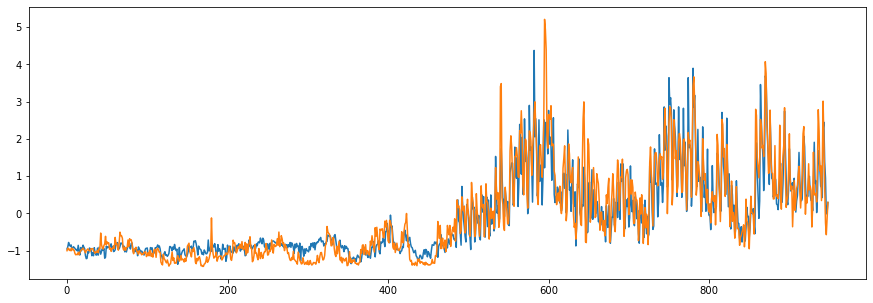

In [324]:
plot_predictions1(model, X2_test, y2_test)